In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk 
from sklearn.ensemble import RandomForestClassifier 
from glob import glob,iglob
from osgeo import gdal , gdal_array
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from write_geotif import CreateGeoTiff
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

from yellowbrick.model_selection import FeatureImportances

from tqdm import tqdm
from joblib import Parallel, delayed
import earthpy.plot as ep
import gc
import os

#import pickle4 as pickle
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix  # Import confusion_matrix

Data processing: to preprocess the data for some predictive modeling task, ensuring proper data types, handling categorical variables, and splitting the data into training and testing sets.

In [2]:
#Reading Data:This line reads a CSV file named "point_final.csv" into a pandas DataFrame (data_org) using pd.read_csv(). The delimiter used in the CSV file is ;.
data_org=pd.read_csv("point_final.csv",delimiter=";")

In [3]:
#Data Preprocessing:Here, a copy of the original DataFrame is created (data) to perform data preprocessing. In this step, commas in the data are replaced with periods. This is likely done to ensure consistency in representing decimal numbers.
data=data_org.copy()
data=data.replace(",",".",regex=True)

In [4]:
#Checking Data Types:This line prints out the data types of each column in the DataFrame data.
data.dtypes

OID_                  int64
Landslide             int64
LONGITUDE            object
LATITUDE             object
DTM_merged           object
slope                object
LULC                  int64
profile_curvature    object
plan_curvature       object
dist_acc_road        object
dist_river           object
NDVI                 object
rain                 object
aspect                int64
dtype: object

In [5]:
#Removing First Column:This line removes the first column from the DataFrame data. It's common in data processing tasks to remove index columns or columns that are not needed for analysis.
data=data.iloc[:,1:]

In [6]:
# Separate features and target variable: Here, the DataFrame X is created containing all the features (independent variables) except for the 'Landslide' column, while y contains only the 'Landslide' column, which is the target variable (dependent variable).
X=data.drop('Landslide', axis=1).copy()
y=data.loc[:,'Landslide'].copy()

In [7]:
X.head()

,LONGITUDE,LATITUDE,DTM_merged,slope,LULC,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,aspect
0,91682.5802,92003.1689,373.0174866,0.787680209,4,-0.06276847,0.033129507,411.9653931,180.7027969,0.362031567,67.34322357,7
1,55682.266,104415.2486,385.8379517,16.82241821,2,-0.269385904,0.087632157,258.0426331,148.4890594,0.335763618,82.88248444,6
2,76261.6868,66915.8101,294.2075043,10.79049492,4,0.272305995,-0.318835378,580.9100647,373.3664398,0.4827781,71.41384125,8
3,56772.518,102116.9275,455.8366547,24.03018665,2,-0.174597126,0.955412209,539.9199219,80.76198578,0.265183495,82.81878662,8
4,67847.8478,81082.7308,315.7912445,2.850139856,4,0.11769855,0.001954662,138.8272247,569.63797,0.463345363,75.07782745,6


In [8]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: Landslide, dtype: int64

In [9]:
#Converting Data Types:This line converts all the columns in DataFrame X to float data type.
X=X.astype(float)
X.dtypes

LONGITUDE            float64
LATITUDE             float64
DTM_merged           float64
slope                float64
LULC                 float64
profile_curvature    float64
plan_curvature       float64
dist_acc_road        float64
dist_river           float64
NDVI                 float64
rain                 float64
aspect               float64
dtype: object

In [10]:
#Converting Categorical Variables:Here, specific columns ('aspect' and 'LULC') are converted to string data type. This might be done in preparation for one-hot encoding categorical variables.
#!!!!!uncomment when you have your aspect as categorical/factor variable fro example 1,2,3,4.....
X['aspect']=X['aspect'].astype(str)
X['LULC']=X['LULC'].astype(str)

In [11]:
#Checking Data Types: This line prints out the data type of the target variable y.
y.dtypes

dtype('int64')

In [12]:
#Identifying Categorical Columns:This line identifies categorical columns in the DataFrame X and stores their column names in the list cols_obj.
cols_obj=X.columns[X.dtypes=='object'].values.tolist()
cols_obj
#One-Hot Encoding Categorical Variables: This line performs one-hot encoding on the categorical variables identified earlier and stores the result in the DataFrame X_encoded.
X_encoded=pd.get_dummies(X,columns=cols_obj)

#Train-Test Split:This line splits the data into training and testing sets using train_test_split() function from scikit-learn. The training set comprises 70% of the data, and stratification is applied based on the target variable y.
X_train, X_test, y_train, y_test=train_test_split(X_encoded,y, random_state=6768, train_size=0.70, stratify=y)



In [13]:
cols_obj

['LULC', 'aspect']

In [14]:
X_train.shape

(799, 26)

In [15]:
X_test.shape

(343, 26)

In [16]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

## RandomForest

Define Random Forest Classifier

In [17]:
clf_rf = RandomForestClassifier(random_state=42)

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


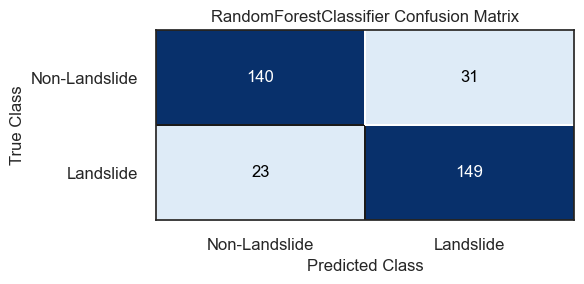

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ConfusionMatrix  # Importing ConfusionMatrix from Yellowbrick

# Define class labels manually (adjust based on your problem)
class_labels = ['Non-Landslide', 'Landslide']

# Train the Classifier
clf_rf.fit(X_train, y_train)

# Customizing seaborn plot style and scale
sns.set(style="white", font_scale=1, rc={"font.weight": "normal"})
sns.set_style(style="white")

# Create figure and axes with a custom size
fig, ax = plt.subplots(figsize=(6, 3))  # Adjust the size here (e.g., smaller height and width)

# Visualizing the confusion matrix using Yellowbrick, and passing in ax
cm_rf = ConfusionMatrix(clf_rf, classes=class_labels, cmap="Blues", ax=ax)  # Pass 'ax' to Yellowbrick

# Fit with the training data
cm_rf.fit(X_train, y_train)

# Score with the test data
cm_rf.score(X_test, y_test)

# Adjust the axis labels' rotation
plt.xticks(rotation=0)  # x-axis labels should be straight
plt.yticks(rotation=0)  # y-axis labels should be tilted by 45 degrees

# Show the plot
cm_rf.show()

# Optionally, save the plot
fig.savefig(r'./confusion_matrix_Randomforest.png', bbox_inches='tight', dpi=300)

# Show the plot in the output
plt.show()


In [19]:
#Hyperparameter Tuning with Grid Search: Here, a dictionary param_grid is defined, which contains the hyperparameters and their respective values to be tuned.
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [20]:
# Grid Search Cross-Validation
optimal_params_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), #change the 
                                 param_grid=param_grid_rf, verbose=2, n_jobs=16, cv=5)

In [21]:
# Fit the grid search to the data
optimal_params_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=16,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 4, 5, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [22]:
# Best Parameters
print("Best parameters found: ", optimal_params_rf.best_params_)

Best parameters found:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


Setting up Random Forest Classifier with Optimal Parameters: Let's create an instance of the Random Forest classifier using the best parameters found by the grid search.

In [23]:
# Train the Random Forest classifier
clf_rf = optimal_params_rf.best_estimator_


In [24]:
# Customizing seaborn plot style and scale
sns.set(style="white", font_scale=1.4, rc={"font.weight": "bold"})
sns.set_style(style="white")

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


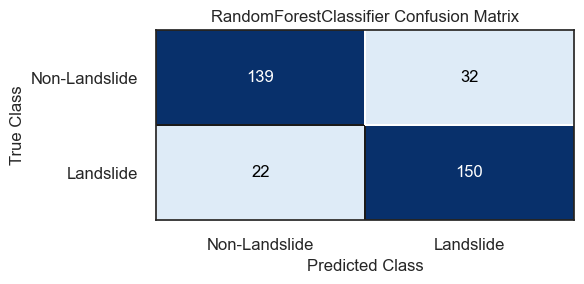

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ConfusionMatrix  # Importing ConfusionMatrix from Yellowbrick

# Define class labels manually (adjust based on your problem)
class_labels = ['Non-Landslide', 'Landslide']

# Train the Classifier
clf_rf.fit(X_train, y_train)

# Customizing seaborn plot style and scale
sns.set(style="white", font_scale=1, rc={"font.weight": "normal"})
sns.set_style(style="white")

# Create figure and axes with a custom size
fig, ax = plt.subplots(figsize=(6, 3))  # Adjust the size here (e.g., smaller height and width)

# Visualizing the confusion matrix using Yellowbrick, and passing in ax
cm_rf = ConfusionMatrix(clf_rf, classes=class_labels, cmap="Blues", ax=ax)  # Pass 'ax' to Yellowbrick

# Fit with the training data
cm_rf.fit(X_train, y_train)

# Score with the test data
cm_rf.score(X_test, y_test)

# Adjust the axis labels' rotation
plt.xticks(rotation=0)  # x-axis labels should be straight
plt.yticks(rotation=0)  # y-axis labels should be tilted by 45 degrees

# Show the plot
cm_rf.show()

# Optionally, save the plot
fig.savefig(r'./confusion_matrix_Randomforest.png', bbox_inches='tight', dpi=300)

# Show the plot in the output
plt.show()


In [26]:
temp = clf_rf.predict_proba(X_train)

In [27]:
temp.min()

0.0

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


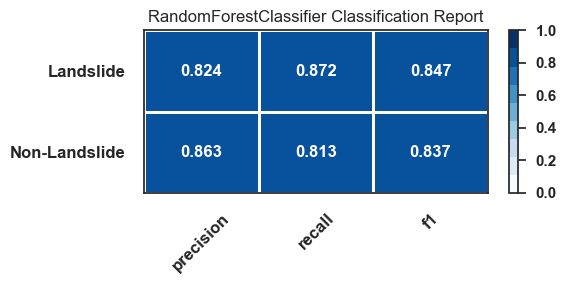

In [28]:
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
import matplotlib.pyplot as plt

# Define class_mapper for your labels
class_mapper = {0: 'Non-Landslide', 1: 'Landslide'}

# Use a Yellowbrick-compatible palette like 'Blues'
visualizer_rf = ClassificationReport(clf_rf, classes=list(class_mapper.values()), support=False, cmap='Blues')

# Set seaborn style
sns.set(style="white", font_scale=1, rc={"font.weight": "bold"})
sns.set_style(style="white")

# Create the plot and fit the visualizer to the training data
fig, ax = plt.subplots(figsize=(6, 3))
visualizer_rf.fit(X_train, y_train)  # Fit the visualizer

# Evaluate on test data
visualizer_rf.score(X_test, y_test)  # Score the visualizer

# Show the plot and save it as an image file
visualizer_rf.show(outpath="./accuracy_assessment_random_forest.png")
fig.tight_layout()


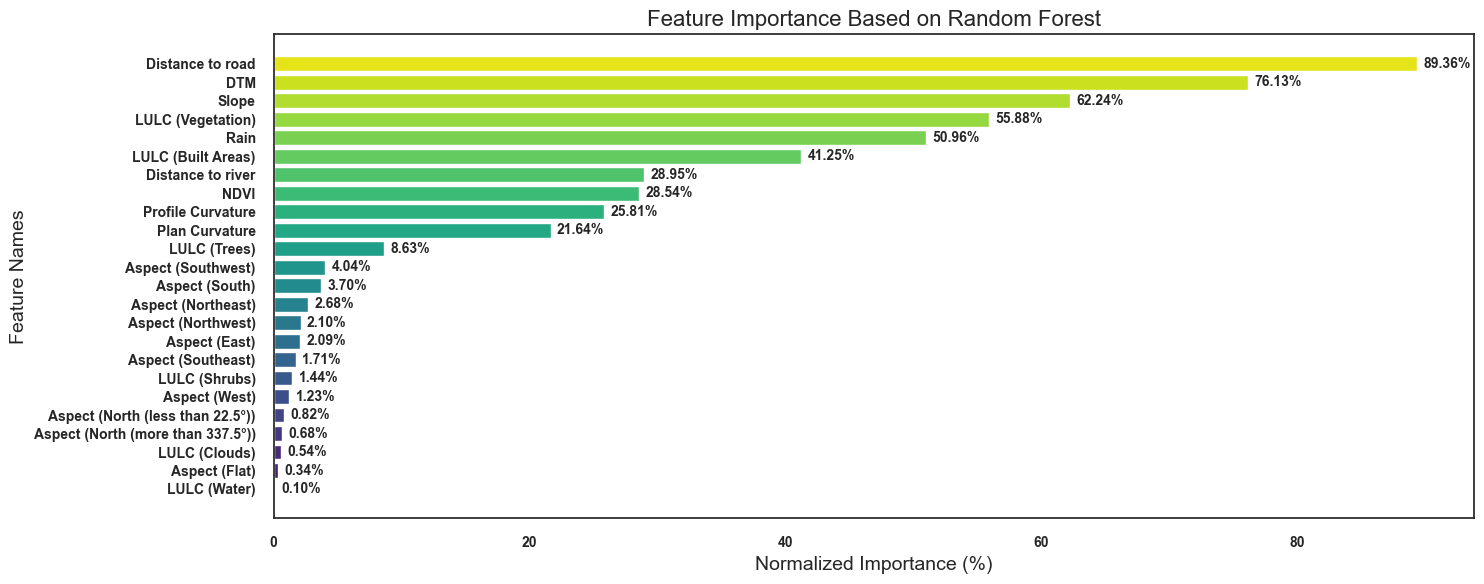

In [47]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np

# Assuming clf_rf is already defined and trained

# Get feature names and importances from RandomForest
names = clf_rf.feature_names_in_
importance_normalized = (clf_rf.feature_importances_ / max(clf_rf.feature_importances_)) * 100

# Create a dictionary of feature importances
importance_dic = dict(zip(names, importance_normalized))

# Filter out features with zero importance and specific features to exclude
features_to_exclude = {'LATITUDE', 'LONGITUDE'}
importance_dic_filtered = {k: v for k, v in importance_dic.items() if v > 0 and k not in features_to_exclude}

# Define feature name mapping (if necessary)
feature_name_mapping = {
    'LULC_4.0': 'LULC (Vegetation)',
    'dist_acc_road': 'Distance to road',
    'slope': 'Slope',
    'DTM_merged': 'DTM',
    'LULC_5.0': 'LULC (Built Areas)',
    'rain': 'Rain',
    'dist_river': 'Distance to river',
    'aspect_5.0': 'Aspect (South)',
    'profile_curvature': 'Profile Curvature',
    'aspect_6.0': 'Aspect (Southwest)',
    'LULC_2.0': 'LULC (Trees)',
    'LULC_0.0': 'LULC (Clouds)',
    'LULC_1.0': 'LULC (Water)',
    'plan_curvature': 'Plan Curvature',
    'aspect_2.0': 'Aspect (Northeast)',
    'LULC_8.0': 'LULC (Shrubs)',
    'aspect_9.0': 'Aspect (North (more than 337.5°))',
    'aspect_3.0': 'Aspect (East)',
    'aspect_1.0': 'Aspect (North (less than 22.5°))',
    'aspect_4.0': 'Aspect (Southeast)',
    'aspect_8.0': 'Aspect (Northwest)',
    'aspect_0.0': 'Aspect (Flat)',
    'aspect_7.0': 'Aspect (West)',
    
}

# Apply the feature name mapping
importance_dic_filtered_renamed = {feature_name_mapping.get(k, k): v for k, v in importance_dic_filtered.items()}

# Sort the dictionary by importance
sort_id = sorted(importance_dic_filtered_renamed, key=lambda x: importance_dic_filtered_renamed[x], reverse=False)
importance_dic_sorted = {k: importance_dic_filtered_renamed[k] for k in sort_id}

# Generate a nice color palette using seaborn
num_colors = len(sort_id)
colours = sns.color_palette("viridis", num_colors)

# Plot the feature importances
fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.barh(list(importance_dic_sorted.keys()), list(importance_dic_sorted.values()), color=colours)

# Customize the plot labels
ax.set_title("Feature Importance Based on Random Forest", fontsize=16)
ax.set_ylabel("Feature Names", fontsize=14)
ax.set_xlabel("Normalized Importance (%)", fontsize=14)

# Customize tick label sizes
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='left', va='center', fontsize=10)

# Adjust layout for better fit
fig.tight_layout()
plt.savefig("C:/temp/project/RF_Feature_Importance.png")  # Save the plot to the specified path
plt.show()


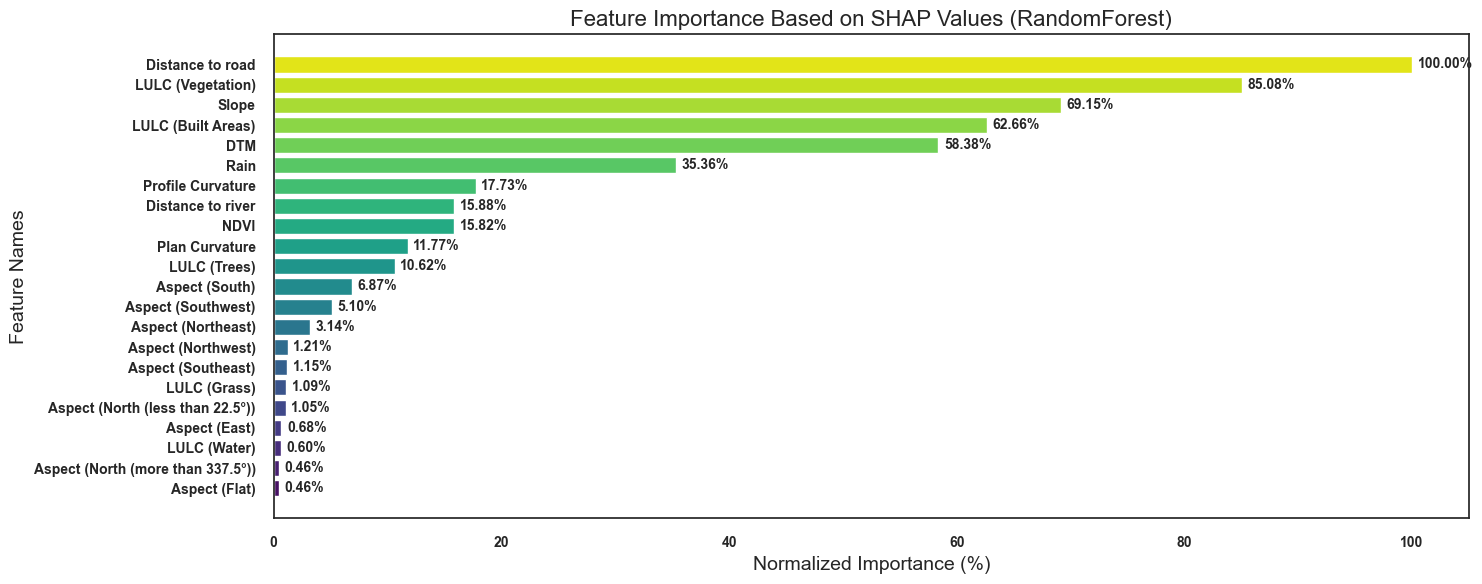

In [46]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming clf_rf is already defined and trained
# and X_train is your training data

# Ensure X_train columns match the features used in the model
expected_features = clf_rf.feature_names_in_
current_features = X_train.columns

# Find the missing and extra features
missing_features = [feature for feature in expected_features if feature not in current_features]
extra_features = [feature for feature in current_features if feature not in expected_features]

# Add missing features with default values (e.g., 0)
for feature in missing_features:
    X_train[feature] = 0

# Drop extra features not expected by the model
X_train = X_train.drop(columns=extra_features)

# Convert all columns to numeric if possible
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Fill remaining NaN values with 0 or some other value as appropriate
X_train = X_train.fillna(0)

# Ensure the feature order matches the model
X_train = X_train[expected_features]

# Define feature name mapping
feature_name_mapping = {
    'LULC_4.0': 'LULC (Vegetation)',
    'dist_acc_road': 'Distance to road',
    'slope': 'Slope',
    'DTM_merged': 'DTM',
    'LULC_5.0': 'LULC (Built Areas)',
    'rain': 'Rain',
    'dist_river': 'Distance to river',
    'aspect_5.0': 'Aspect (South)',
    'profile_curvature': 'Profile Curvature',
    'aspect_6.0': 'Aspect (Southwest)',
    'LULC_2.0': 'LULC (Trees)',
    'plan_curvature': 'Plan Curvature',
    'aspect_2.0': 'Aspect (Northeast)',
    'LULC_8.0': 'LULC (Grass)',
    'LULC_0.0': 'LULC (Water)',
    'LULC_1.0': 'LULC (Trees)',
    'aspect_9.0': 'Aspect (North (more than 337.5°))',
    'aspect_3.0': 'Aspect (East)',
    'aspect_4.0': 'Aspect (Southeast)',
    'aspect_8.0': 'Aspect (Northwest)',
    'aspect_0.0': 'Aspect (Flat)',
    'aspect_7.0': 'Aspect (East)',
    'aspect_1.0': 'Aspect (North (less than 22.5°))'
}

# Apply the feature name mapping
X_train_renamed = X_train.rename(columns=feature_name_mapping)

# Create the SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer.shap_values(X_train_renamed)

# For binary classification, use the SHAP values for the positive class
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use the SHAP values for the positive class

# Extract mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values).mean(axis=0)
names = X_train_renamed.columns

# Convert shap_importance to a 1D numpy array if it is not already
if isinstance(shap_importance, np.ndarray) and shap_importance.ndim > 1:
    shap_importance = shap_importance.mean(axis=1)

# Normalize SHAP values to a percentage scale
importance_normalized = (shap_importance / np.max(shap_importance)) * 100

# Create a dictionary of feature importances
importance_dic = dict(zip(names, importance_normalized))

# Filter out features with zero importance and specific features to exclude
features_to_exclude = {'LATITUDE', 'LONGITUDE'}
importance_dic_filtered = {k: v for k, v in importance_dic.items() if v > 0 and k not in features_to_exclude}

# Sort the dictionary by importance in descending order
sort_id = sorted(importance_dic_filtered, key=lambda x: importance_dic_filtered[x], reverse=True)
importance_dic_sorted = {k: importance_dic_filtered[k] for k in sort_id}

# Generate a nice color palette using seaborn
num_colors = len(sort_id)
colours = sns.color_palette("viridis", num_colors)

# Reverse the order of the sorted dictionary for the bar chart
sorted_feature_names = list(importance_dic_sorted.keys())[::-1]
sorted_importance_values = list(importance_dic_sorted.values())[::-1]

# Plot the feature importances in descending order (high to low)
fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.barh(sorted_feature_names, sorted_importance_values, color=colours)

# Customize the plot labels
ax.set_title("Feature Importance Based on SHAP Values (RandomForest)", fontsize=16)
ax.set_ylabel("Feature Names", fontsize=14)
ax.set_xlabel("Normalized Importance (%)", fontsize=14)

# Customize tick label sizes
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='left', va='center', fontsize=10)

# Adjust layout for better fit
fig.tight_layout()
plt.savefig("C:/temp/project/SHAP_Values_RandomForest.png")  # Save the plot to the specified path
plt.show()


Shape of shap_values_class_1: (799, 26, 2)
Shape of X_train_renamed (dataset): (799, 26)


<Figure size 1500x800 with 0 Axes>

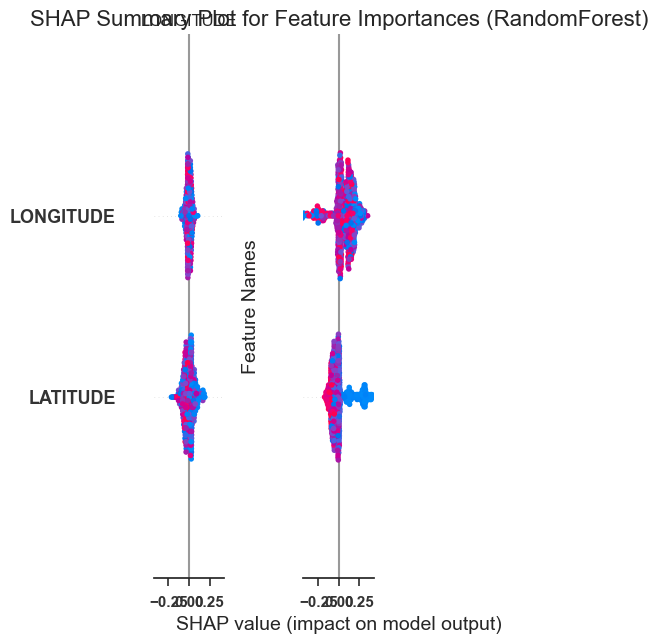

In [31]:
import shap
import matplotlib.pyplot as plt

# Assuming clf_rf is your trained RandomForest model and X_train_renamed is your dataset

# Create SHAP explainer
explainer = shap.TreeExplainer(clf_rf)

# Compute SHAP values for the entire dataset
shap_values = explainer.shap_values(X_train_renamed)

# Check if shap_values is a list (for multi-class classification)
if isinstance(shap_values, list):
    # shap_values will have one array per class; select the class you want (usually 1 for binary classification)
    shap_values_class_1 = shap_values[1]
else:
    # For regression or single-class, use shap_values directly
    shap_values_class_1 = shap_values

# Print shapes for debugging
print("Shape of shap_values_class_1:", shap_values_class_1.shape)
print("Shape of X_train_renamed (dataset):", X_train_renamed.shape)

# Ensure that the number of samples and features match between SHAP values and the dataset
if shap_values_class_1.shape[0] != X_train_renamed.shape[0] or shap_values_class_1.shape[1] != X_train_renamed.shape[1]:
    raise ValueError("The SHAP values and the dataset don't match in shape.")

# Generate SHAP summary plot with all features for the second class
plt.figure(figsize=(15, 8))  # Adjust the size of the plot as needed
shap.summary_plot(shap_values_class_1, X_train_renamed, show=False)
plt.title('SHAP Summary Plot for Feature Importances (RandomForest)', fontsize=16)
plt.xlabel('SHAP value (impact on model output)', fontsize=14)
plt.ylabel('Feature Names', fontsize=14)
plt.tight_layout()
plt.show()


C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Cohen's Kappa Score (RandomForest): 0.685


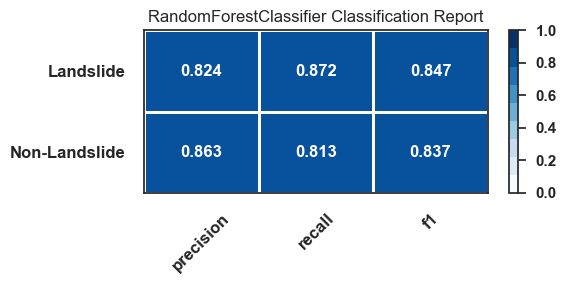

In [32]:
from sklearn.metrics import cohen_kappa_score, classification_report
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming clf_rf is your trained RandomForest model
# Set visualizer for classification report
visualizer = ClassificationReport(clf_rf, classes=list(class_mapper.values()), support=False, cmap='Blues')

# Set Seaborn styling
sns.set(style="white", font_scale=1, rc={"font.weight": "bold"})
sns.set_style(style="white")

# Create figure and axes for plot
fig, ax = plt.subplots(figsize=(6, 3))

# Fit and evaluate the visualizer with the RandomForest model
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

# Save the classification report as an image
visualizer.show(outpath="C:/temp/project/accuracy_assessment_RandomForest.png")
fig.tight_layout()

# Calculate the Kappa value for the RandomForest model
y_pred_rf = clf_rf.predict(X_test)  # Get predictions from RandomForest
y_true = y_test  # True labels

plt.savefig("C:/temp/project/RandomForestClassfier.png")  # Save the plot to the specified path

# Cohen's Kappa Score
kappa_rf = cohen_kappa_score(y_true, y_pred_rf)
print(f"Cohen's Kappa Score (RandomForest): {kappa_rf:.3f}")
